<a href="https://colab.research.google.com/github/Ankit-Raj-2721/Stock-Market-Trend-Prediction/blob/main/Stock_Market_Trend_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
file_path = '/content/drive/My Drive/stock_data.csv'

In [40]:
df = pd.read_csv(file_path)

In [41]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close
0,0,27-03-2018,173.68,175.15,166.92,168.340
1,1,26-03-2018,168.07,173.10,166.44,172.770
2,2,23-03-2018,168.39,169.92,164.94,164.940
3,3,22-03-2018,170.00,172.68,168.60,168.845
4,4,21-03-2018,175.04,175.09,171.26,171.270


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9400 non-null   int64  
 1   Date        9400 non-null   object 
 2   Open        9400 non-null   float64
 3   High        9400 non-null   float64
 4   Low         9400 non-null   float64
 5   Close       9400 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 440.8+ KB


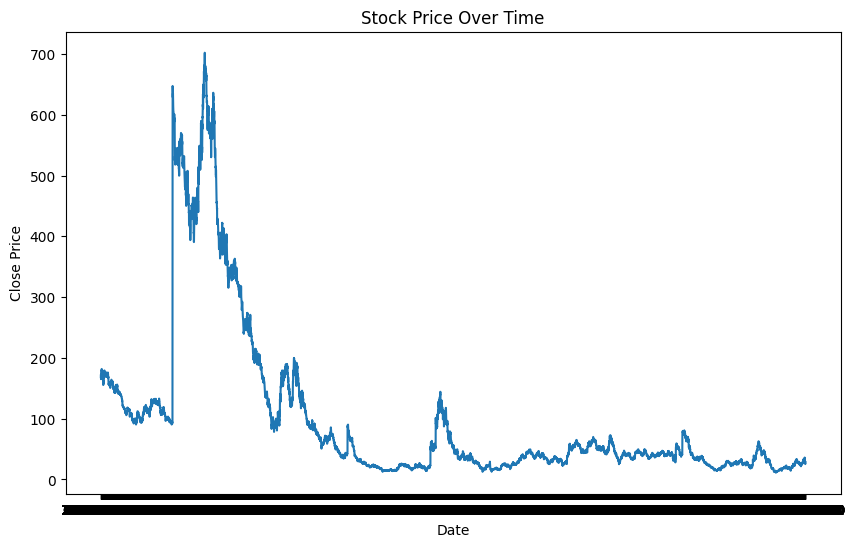

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [44]:
#data preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))


In [45]:
scaled_data

array([[0.22766604],
       [0.23407611],
       [0.22274635],
       ...,
       [0.0206193 ],
       [0.02351324],
       [0.02568369]])

In [46]:
#data preparation
def prepare_data(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i: (i + time_step), 0])
        Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)

In [47]:
time_step = 60
X_train, Y_train = prepare_data(scaled_data, time_step)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [48]:
X_train

array([[[0.22766604],
        [0.23407611],
        [0.22274635],
        [0.22839676],
        [0.23190566],
        [0.23765012],
        [0.23773694],
        [0.2416727 ],
        [0.24258429],
        [0.24228042],
        [0.24449428],
        [0.24702648],
        [0.24450875],
        [0.24010997],
        [0.23734626],
        [0.23971929],
        [0.23993633],
        [0.23905368],
        [0.23730285],
        [0.24181739],
        [0.24220807],
        [0.24304732],
        [0.23810592],
        [0.23383013],
        [0.23161626],
        [0.2327449 ],
        [0.23358414],
        [0.23439444],
        [0.22626248],
        [0.22187817],
        [0.21951961],
        [0.20976704],
        [0.20882651],
        [0.21493272],
        [0.21998264],
        [0.21196643],
        [0.2161337 ],
        [0.22685574],
        [0.2263493 ],
        [0.22568369],
        [0.22711619],
        [0.23225293],
        [0.23167414],
        [0.23617422],
        [0.24025467],
        [0

In [63]:
from tensorflow.keras.layers import Input

generator = Sequential([
    Input(shape=(100,)),
    Dense(128),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(momentum=0.8),
    Dense(256),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(momentum=0.8),
    Dense(512),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(momentum=0.8),
    Dense(time_step),
    Reshape((time_step, 1))
])

In [64]:
from tensorflow.keras.layers import Input

discriminator = Sequential([
    Input(shape=(time_step, 1)),
    Flatten(),
    Dense(512),
    LeakyReLU(negative_slope=0.2),
    Dense(256),
    LeakyReLU(negative_slope=0.2),
    Dense(1, activation='sigmoid')
])
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
#Building combined model
discriminator.trainable = False
GAN = Sequential([generator, discriminator])
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [66]:
def train_gan(X_train, epochs, batch_size=128, save_interval=50):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        #  Train Discriminator
        discriminator.trainable = True

        # Train on a batch of real and generated data
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_data = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        generated_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  Train Generator

        # Freeze the discriminator's weights when training the generator via the GAN model.
        discriminator.trainable = False

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = GAN.train_on_batch(noise, valid_y)

        # Print progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f} | D acc: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

train_gan(X_train, epochs=1000, batch_size=32, save_interval=200)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
0 [D loss: 0.6930 | D acc: 10.94%] [G loss: 1.0271]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


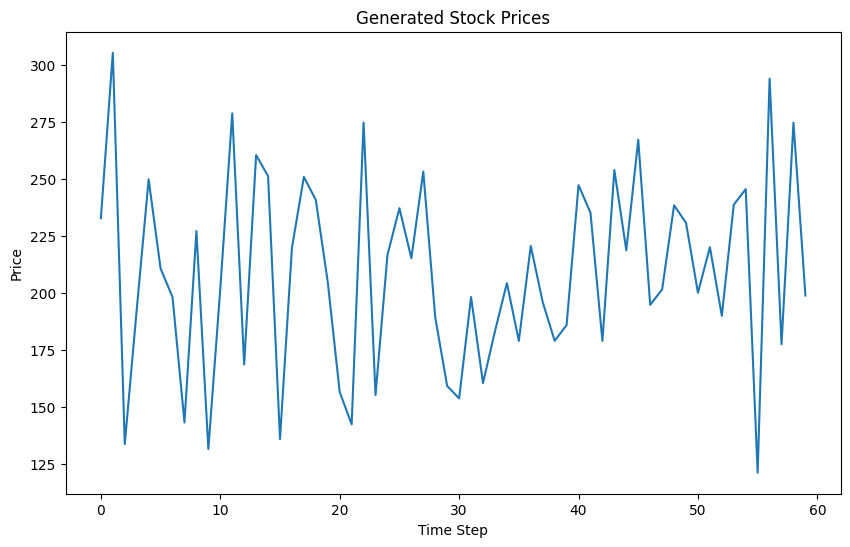

In [67]:
noise = np.random.normal(0,1,(1,100))
generated_stock_prices = generator.predict(noise)
generated_stock_prices = scaler.inverse_transform(generated_stock_prices.reshape(-1, 1))
plt.figure(figsize=(10, 6))
plt.plot(range(len(generated_stock_prices)), generated_stock_prices)
plt.title('Generated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.show()

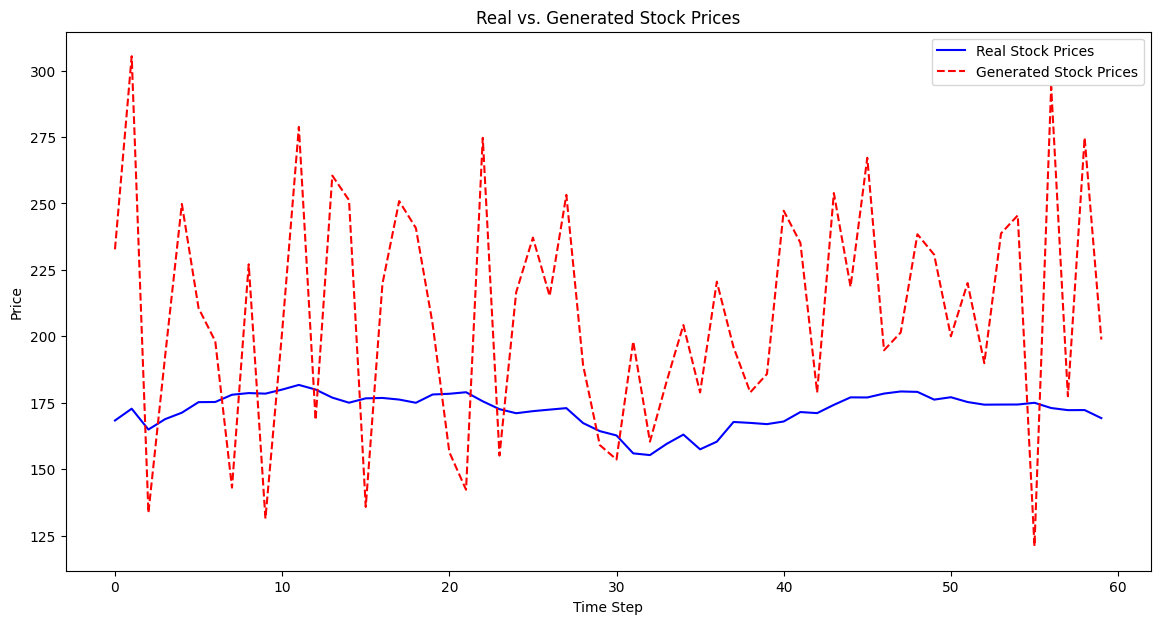

In [68]:
#Evaluation
real_stock_prices = scaler.inverse_transform(X_train[-0].reshape(-1, 1))
#Plotting the real stock prices
plt.figure(figsize=(14, 7))
plt.plot(real_stock_prices, color='blue', label='Real Stock Prices')
plt.plot(generated_stock_prices, color='red', linestyle='--', label='Generated Stock Prices')
plt.title('Real vs. Generated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [69]:
mse=mean_squared_error(real_stock_prices, generated_stock_prices)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3087.7745322654673
